# Buliding two-layer Neural Network from scratch
- Neural Network without using any Deep Learning Library
- Dataset: [MNIST Database of Handwritten Digits](http://yann.lecun.com/exdb/mnist/)

## Importing Libraries

In [ ]:
import random
import numpy as np
import pandas as pd
import time

## Importing Datasets
For importing 'idx' file type [this link](https://stackoverflow.com/a/55504575) was referred.

In [ ]:
%%bash
mkdir Data
cd Data
wget -q http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz 
wget -q http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz 
wget -q http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz 
wget -q http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz 

In [ ]:
%%bash
cd Data
gzip -d train-images-idx3-ubyte.gz 
gzip -d train-labels-idx1-ubyte.gz 
gzip -d t10k-images-idx3-ubyte.gz 
gzip -d t10k-labels-idx1-ubyte.gz 

In [ ]:
!pip install idx2numpy
import idx2numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7917 sha256=8596b2e6e4aeaeb107b80e3705168f02893cf6b4368f04be37e69da643ebd96b
  Stored in directory: /root/.cache/pip/wheels/1a/ce/ad/d5e95a35cfe34149aade5e500f2edd535c0566d79e9a8e1d8a
Successfully built idx2numpy


In [ ]:
# Importing Train Image
file = 'Data/train-images-idx3-ubyte'
arr = idx2numpy.convert_from_file(file)
train_images = [arr[i].reshape(784,1)/255 for i in range(60000)]
del arr

# Importing Train Label
file = 'Data/train-labels-idx1-ubyte'
arr = idx2numpy.convert_from_file(file)
train_labels = np.zeros((60000,10,1))                     
for i in range(60000):
    train_labels[i,arr[i],0] = 1
del arr

# Zipping the Training data
train_data = list(zip(train_images,train_labels))
del train_images, train_labels

In [ ]:
# Importing Test Image
file = 'Data/t10k-images-idx3-ubyte'
arr = idx2numpy.convert_from_file(file)
test_images = [arr[i].reshape(784,1)/255 for i in range(10000)]
del arr

# Importing Test Label
file = 'Data/t10k-labels-idx1-ubyte'
test_labels = idx2numpy.convert_from_file(file)

# Zipping the Test data
test_data = list(zip(test_images,test_labels))
del test_images, test_labels

## Defining the Neural Network class

In [ ]:
class neural_network(object):
    def __init__(self,layers):
        self.num_layers = len(layers)
        self.biases = [np.random.randn(x,1) for x in layers[1:]]
        self.weights = [np.random.randn(x,y) for x,y in zip(layers[1:],layers[:-1])]
    
    
    def fit(self,train_data,epoch,batch_size,learn_rate,test_data):
        for e in range(epoch):
            print("Training the ANN in Epoch {0} of {1}".format(e+1,epoch))
            random.shuffle(train_data)
            batches = [train_data[i:i+batch_size] for i in range(0,len(train_data),batch_size)]
            
            for batch in batches:
                self.stochastic_GD(batch,learn_rate)
                
#             print('The correct predictions by the learning-ANN after epoch {0}: {1}/10000'\
#                   .format(e+1,self.evaluate(test_data)))
         
        print("\n-----THE-NEURAL-NETWORK-HAS-LEARNED-----")
        
    
    def stochastic_GD(self,batch,learn_rate):
        sum_delta_w = [np.zeros(w.shape) for w in self.weights]
        sum_delta_b = [np.zeros(b.shape) for b in self.biases]
        
        for x,y in batch:
            delta_w , delta_b = self.back_propogation(x,y)
            
            sum_delta_w = [sd_w+d_w for sd_w, d_w in zip(sum_delta_w,delta_w)]
            sum_delta_b = [sd_b+d_b for sd_b, d_b in zip(sum_delta_b,delta_b)]
            
        self.weights = [w-(learn_rate/len(batch))*sd_w for sd_w, w in zip(sum_delta_w, self.weights)]
        self.biases = [b-(learn_rate/len(batch))*sd_b for sd_b, b in zip(sum_delta_b, self.biases)]     
    
    
    def back_propogation(self,x,y):
        # Forward Propogation
        a = x
        node_sums = []
        activations = [a]
        
        for w, b in zip(self.weights, self.biases):
            z = (np.dot(w,a) + b)
            a = sigmoid(z)
            
            node_sums.append(z)
            activations.append(a)
            
        # Backward Propogation
        delta_w = [np.zeros(w.shape) for w in self.weights]
        delta_b = [np.zeros(b.shape) for b in self.biases]
        
        sig_prime = sigmoid_prime(node_sums[-1])
        delta = self.output_loss(activations[-1],y)*sig_prime
    
        delta_b[-1] = delta
        delta_w[-1] = np.dot(delta,activations[-2].transpose())
        
        for l in range(2, self.num_layers):
            z = node_sums[-l]
            sig_prime = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(),delta) * sig_prime
            
            delta_b[-l] = delta
            delta_w[-l] = np.dot(delta,activations[-l-1].transpose())
            
        return (delta_w, delta_b)
    
    
    def output_loss(self, predicted, y):
        return(predicted - y)

    
    def forward_propogation(self, a):
        for w, b in zip(self.weights, self.biases):
            a = sigmoid(np.dot(w,a)+b)
        return a

    
    def evaluate(self, test_data):
        test_results = [(np.argmax(self.forward_propogation(x)), y) for (x, y) in test_data]
        return sum(int(x==y) for (x, y) in test_results)        
    
    
    def predict(self,test_sample):
        predicted = np.argmax(self.forward_propogation(test_sample))
        return predicted
    
    
# Auxiliary Functions    
def sigmoid(z):
    return (1/(1+np.exp(-1*z)))
    
def sigmoid_prime(z):
    return (np.exp(-1*z)/((1+np.exp(-1*z))**2))

## Executing the Neural Network

### Building the Neural Network 

In [ ]:
ANN = neural_network([784,28,10])
print('\nThe initialized ANN predicted {0}% of the test dataset correctly.'.format(ANN.evaluate(test_data)/100))


The initialized ANN predicted 9.29% of the test dataset correctly.


### Training the Neural Network 

In [ ]:
seconds = time.time()
ANN.fit(train_data=train_data,batch_size=6,epoch=10,learn_rate=2, test_data = test_data)
print("\n\tTrain Time = {0}s".format(round((time.time()-seconds),3)))

Training the ANN in Epoch 1 of 10
Training the ANN in Epoch 2 of 10
Training the ANN in Epoch 3 of 10
Training the ANN in Epoch 4 of 10
Training the ANN in Epoch 5 of 10
Training the ANN in Epoch 6 of 10
Training the ANN in Epoch 7 of 10
Training the ANN in Epoch 8 of 10
Training the ANN in Epoch 9 of 10
Training the ANN in Epoch 10 of 10

-----THE-NEURAL-NETWORK-HAS-LEARNED-----

	Train Time = 118.078s


### Testing the accuracy of Neural Network

In [ ]:
print('\nThe learned ANN predicted {0}% of the test dataset correctly.'.format(ANN.evaluate(test_data)/100))


The learned ANN predicted 94.6% of the test dataset correctly.


### Individual Prediction 

In [ ]:
sample, sample_label = test_data[random.randint(0,10000)]

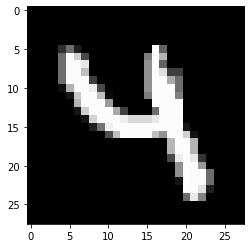

ANN predicts: 4 	 Actual: 4


In [ ]:
from matplotlib import pyplot as plt
plt.imshow(sample.reshape(28,28), cmap=plt.get_cmap('gray'))
plt.show()
print("ANN predicts:",ANN.predict(sample),"\t Actual:",sample_label)

---